In [20]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [29]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from matplotlib import pyplot as plt

1. Loading and Exploring Data

In [22]:
df = pd.read_csv('data/processed/Churn_modelling_binning.csv')
df.head()

,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScoreBins
0,France,Female,3.76120,2,0.00,1,1,1,101348.88,1,Fair
1,Spain,Female,3.73767,1,83807.86,1,0,1,112542.58,0,Fair
2,France,Female,3.76120,8,159660.80,3,1,0,113931.57,1,Poor
3,France,Female,3.68668,1,0.00,2,0,0,93826.63,0,Good
4,Spain,Female,3.78419,2,125510.82,1,1,1,79084.10,0,Excellent


2. Build Scikit-learn Pipelines

In [23]:
nominal_features = ['Gender','Geography']
ordinal_features = ['CreditScoreBins']
numerical_features = ['Age','Tenure','Balance','EstimatedSalary']
remainder_features = ['NumOfProducts','HasCrCard','IsActiveMember','Exited']


numerical_transformer = Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy='median')),
        ('scalar',StandardScaler())
    ]
)

nominal_transformer = Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy='constant',
                                 fill_value='missing'
                                )),
        ('encoder',OneHotEncoder())
    ]
)


ordinal_transformer = Pipeline(
    steps=[
        ('imputer',SimpleImputer(
            strategy='constant',
            fill_value='missing'
            )),
        ('encoder',OrdinalEncoder())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer,numerical_features),
        ('nom', nominal_transformer,nominal_features),
        ('ord', ordinal_transformer,ordinal_features)
    ],
    remainder='drop'    
)

nominal_feature_names = []
for feature in nominal_features:
    unique_values = df[feature].unique()
    nominal_feature_names.extend([f"{feature}_{val}" for val in unique_values])

df_cp = df.copy()
df_transformed = pd.DataFrame(
    preprocessor.fit_transform(df_cp),
    columns=numerical_features+nominal_feature_names+ordinal_features
)

df_remainder = df[remainder_features]
df_pp = pd.concat(
                    [df_transformed, df_remainder],
                    axis=1
                 )

In [24]:
df_pp.to_csv(
    'data/processed/X_Transformed.csv',index=False
)

3. Handle Class Imbalance

In [25]:
X = df_pp.drop(columns=['Exited'])
Y = df_pp['Exited']

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(
                    X, Y,
                    test_size=0.2,
                    random_state=42
)

In [28]:
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

Text(0, 0.5, 'Count')

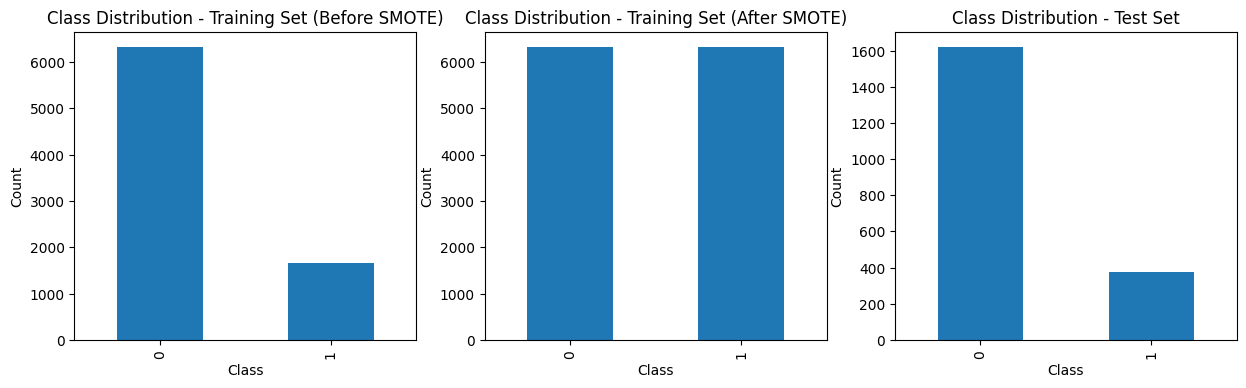

In [31]:
plt.figure(figsize=(15,4))

# Before SMOTE
plt.subplot(131)
Y_train.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Set (Before SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

# After SMOTE
plt.subplot(132)
Y_train_resampled.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Set (After SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

# Test Set
plt.subplot(133)
Y_test.value_counts().plot(kind='bar')
plt.title('Class Distribution - Test Set')
plt.xlabel('Class')
plt.ylabel('Count')